# **BirdCLEF 2025 Data Preprocessing Notebook**
This notebook demonstrates how we can transform audio data into mel-spectrogram data. This transformation is essential for training 2D Convolutional Neural Networks (CNNs) on audio data, as it converts the one-dimensional audio signals into two-dimensional image-like representations.
I run this public notebook in debug mode(only a few sample processing). You can find the fully preprocessed mel spectrogram training dataset here --> [BirdCLEF'25 | Mel Spectrograms](https://www.kaggle.com/datasets/kadircandrisolu/birdclef25-mel-spectrograms).


In [1]:
import cv2
import time
import os
import librosa
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
class Config:
 
    DEBUG_MODE = False
    
    OUTPUT_DIR = 'archive/'
    DATASET_NAME = 'train_soundscapes_melspec_12x5_256_256'
    SOUNDSCAPE_DIR = "birdclef-2025/train_soundscapes"
    FS = 32000
    
    # Mel spectrogram parameters
    N_FFT = 1024
    HOP_LENGTH = 512
    N_MELS = 128
    FMIN = 50
    FMAX = 14000
    WINDOW_SIZE = 5
    
    TARGET_DURATION = 5.0
    TARGET_SHAPE = (256, 256)  
    
    N_MAX = 50 if DEBUG_MODE else None  

config = Config()

os.makedirs(f"{config.OUTPUT_DIR}{config.DATASET_NAME}", exist_ok=True)

In [3]:
print(f"Debug mode: {'ON' if config.DEBUG_MODE else 'OFF'}")
print(f"Max samples to process: {config.N_MAX if config.N_MAX is not None else 'ALL'}")

Debug mode: OFF
Max samples to process: ALL


In [4]:
filepaths = [f"{config.SOUNDSCAPE_DIR}"+"/"+f"{name}" for name in os.listdir(config.SOUNDSCAPE_DIR)]
working_df = pd.DataFrame({"filepath":filepaths})
working_df['samplename'] = working_df.filepath.map(lambda x: x.split('/')[-1].split('.')[0])
total_samples = min(len(working_df), config.N_MAX or len(working_df))
with open('sample_list.csv', 'w') as f:
    working_df.to_csv(f)
print(f'Total samples to process: {total_samples} out of {len(working_df)} available')

Total samples to process: 9726 out of 9726 available


In [5]:
def audio2melspec(audio_data):
    if np.isnan(audio_data).any():
        mean_signal = np.nanmean(audio_data)
        audio_data = np.nan_to_num(audio_data, nan=mean_signal)

    mel_spec = librosa.feature.melspectrogram(
        y=audio_data,
        sr=config.FS,
        n_fft=config.N_FFT,
        hop_length=config.HOP_LENGTH,
        n_mels=config.N_MELS,
        fmin=config.FMIN,
        fmax=config.FMAX,
        power=2.0
    )

    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min() + 1e-8)
    
    return mel_spec_norm

In [6]:
def process_audio_segment(audio_data):
    """Process audio segment to get mel spectrogram"""
    if len(audio_data) < config.FS * config.WINDOW_SIZE:
        audio_data = np.pad(audio_data, 
                          (0, config.FS * config.WINDOW_SIZE - len(audio_data)), 
                          mode='constant')
    
    mel_spec = audio2melspec(audio_data)
    
    if mel_spec.shape != config.TARGET_SHAPE:
        mel_spec = cv2.resize(mel_spec, config.TARGET_SHAPE, interpolation=cv2.INTER_LINEAR)
        
    return mel_spec.astype(np.float32)

In [7]:
print("Starting audio processing...")
print(f"{'DEBUG MODE - Processing only 50 samples' if config.DEBUG_MODE else 'FULL MODE - Processing all samples'}")
start_time = time.time()

# Dictionary to track processed files (metadata only, not the actual spectrograms)
all_bird_metadata = {}
errors = []
processed_count = 0

# Instead of one big H5 file, save individual numpy files
# Create a metadata CSV to keep track of all files
metadata_df = pd.DataFrame(columns=['filepath', 'samplename'])

try:
    # Process and save each spectrogram individually
    for i, row in tqdm(working_df.iterrows(), total=total_samples):
        if config.N_MAX is not None and i >= config.N_MAX:
            break
        
        try:
            audio_data, _ = librosa.load(row.filepath, sr=config.FS)
            total_segments = int(len(audio_data) / (config.FS * config.WINDOW_SIZE))
            
            for segment_idx in range(total_segments):
                start_sample = segment_idx * config.FS * config.WINDOW_SIZE
                end_sample = start_sample + config.FS * config.WINDOW_SIZE
                segment_audio = audio_data[start_sample:end_sample]
                
                end_time_sec = (segment_idx + 1) * config.WINDOW_SIZE
                row_id = f"{row.samplename}_{end_time_sec}"
                
                # Process the audio segment
                mel_spec = process_audio_segment(segment_audio)
                
                # Save each spectrogram as a separate numpy file
                spec_filepath = f"{config.OUTPUT_DIR}{config.DATASET_NAME}/{row_id}.npy"
                np.save(spec_filepath, mel_spec)
                
                # Add to metadata
                metadata_df.loc[len(metadata_df)] = [spec_filepath, row_id]
                
                # Track metadata only (not the actual data)
                all_bird_metadata[row_id] = True
                processed_count += 1
            
        except Exception as e:
            print(f"Error processing {row.filepath}: {e}")
            errors.append((row.filepath, str(e)))
    
    # Save metadata to CSV
    metadata_filepath = f"{config.OUTPUT_DIR}{config.DATASET_NAME}_metadata.csv"
    metadata_df.to_csv(metadata_filepath)
    print(f"Metadata saved to {metadata_filepath}")
    
except Exception as e:
    print(f"Error during processing: {e}")
    import traceback
    traceback.print_exc()

end_time = time.time()
print(f"Processing completed in {end_time - start_time:.2f} seconds")
print(f"Successfully processed {processed_count} segments out of {total_samples*12} total")
print(f"Failed to process {len(errors)} files")

Starting audio processing...
FULL MODE - Processing all samples


  0%|          | 0/9726 [00:00<?, ?it/s]

Metadata saved to archive/train_soundscapes_melspec_12x5_256_256_metadata.csv
Processing completed in 3414.16 seconds
Successfully processed 116712 segments out of 116712 total
Failed to process 0 files


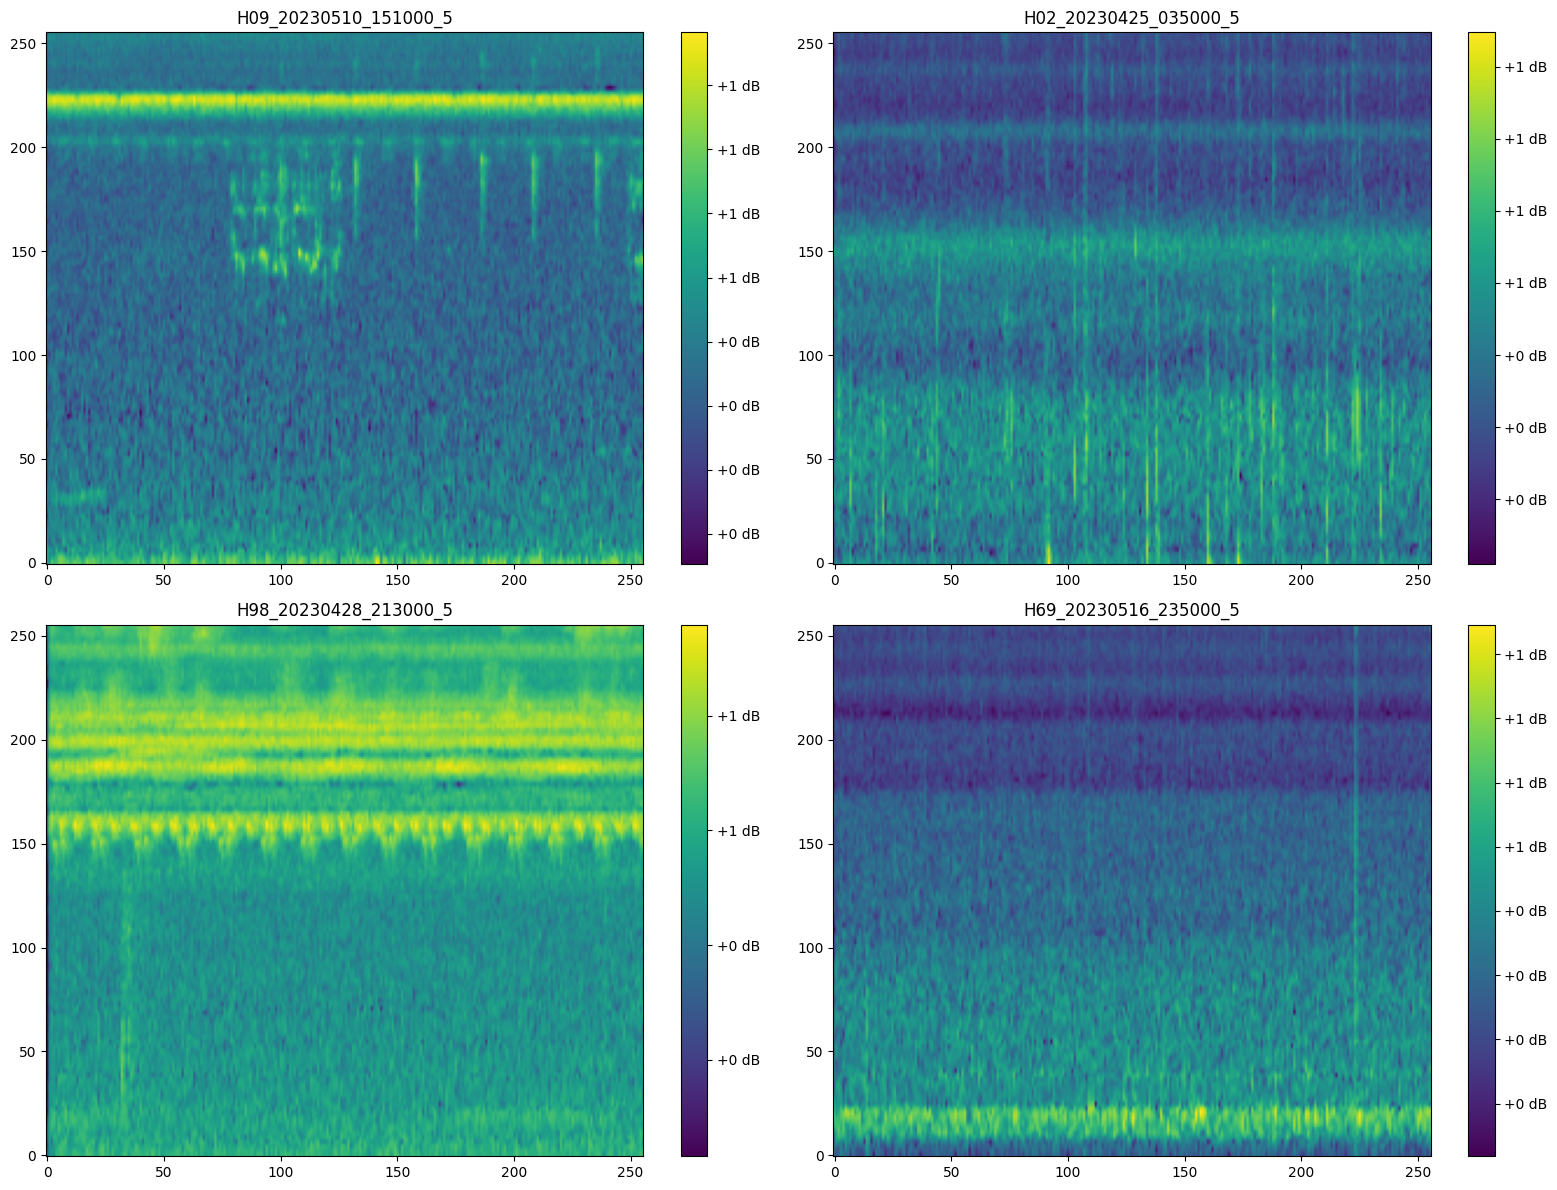

In [18]:
import matplotlib.pyplot as plt

samples = []
max_samples = min(4, len(all_bird_metadata))

for i, row in working_df.iterrows():
    if i >= (config.N_MAX or len(working_df)):
        break
        
    samplename = f"{row['samplename']}_5" #show first 5 seconds 
    samples.append(samplename)
    if len(samples) >= max_samples:  
        break

if samples:
    plt.figure(figsize=(16, 12))
    
    for i, samplename in enumerate(samples):
        spec_filepath = f"{config.OUTPUT_DIR}{config.DATASET_NAME}/{samplename}.npy"
        if os.path.exists(spec_filepath):
            mel_spec = np.load(spec_filepath)
            plt.subplot(2, 2, i+1)
            plt.imshow(mel_spec, aspect='auto', origin='lower', cmap='viridis')
            plt.title(f"{samplename}")
            plt.colorbar(format='%+2.0f dB')
        else:
            print(f"File {spec_filepath} not found.")
    
    plt.tight_layout()
    debug_note = "debug_" if config.DEBUG_MODE else ""
    #plt.savefig(f'{debug_note}melspec_examples.png')
    plt.show()